In [1]:
import urllib.request
import random
import re
import string
from warnings import filterwarnings
filterwarnings('ignore')
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ShuffleSplit, KFold, cross_val_score
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize, LabelEncoder
le = LabelEncoder()
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import gensim.corpora as corpora
import gensim
import pyLDAvis

import nltk as nl
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import gutenberg #corpus here to define as a semantically oriented dictionary of gutenberg
nl.download('stopwords')
nl.download('wordnet')
nl.download('punkt')
nl.download('omw-1.4')
stop_words=set(stopwords.words("english"))

/home/ahmed/anaconda3/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
[nltk_data] Downloading package stopwords to /home/ahmed/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ahmed/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ahmed/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ahmed/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Helper Functions

In [2]:
def OneHotEncoding(y_train, y_test):
    y_train_encoded = label_binarize(y_train, classes=[0, 1, 2, 3, 4])
    y_test_encoded = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
    return y_train_encoded, y_test_encoded
    
def EncodeLabel(y):
    le.fit(y)
    y_encoded =le.transform(y)
    
    return y_encoded

def getAccuracy (model, x, y):
    return accuracy_score(x,y)* 100

def classify(X_train, y_train, X_test, clf):
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    return clf, predicted


def classify_train(X_train, y_train, clf):
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_train)
    return clf, predicted

def ModelAssemesment(y_test, prediction, classifier):
    '''
        1- get accuracy of a classifier.
        2- plot confusion matrix.
    '''
    
    cm = confusion_matrix(y_test, prediction)
    cmDisp = ConfusionMatrixDisplay(cm, display_labels=classifier.classes_) 
    cmDisp.plot()
    plt.show()
    return accuracy_score(y_test, prediction)


def split_train_tst(df: pd.DataFrame):
    return train_test_split(df.iloc[:, 0], df.iloc[:, 1])


def clfer(X_train,Y_train,X_test,Y_test,clf):
    model= clf
    model.fit(X_train, Y_train)
    preds = model.predict(X_test)
    print('ngram ',clf,' Accuracy:',model.score(X_test,Y_test)*100)
    print('ngram ',clf,' Accuracy:',getAccuracy(model,X_test,Y_test))
    print(confusion_matrix(Y_test, preds))
    print(classification_report(Y_test, preds))
    plot_confusion_matrix(model, X_test, Y_test)
    

def cross_validation(clf, num_of_ShuffleSplit, num_of_KFold ,test_size, X_train, y_train ):
    print("Accuracy using cross validation with 10-Fold")
    kf = KFold(n_splits=num_of_KFold,shuffle=True,random_state=0)
    scores = cross_val_score(clf, X_train, y_train, cv=kf)
    i=0
    for score in scores:
        i+=1
        print(" Iteration: %r Accuracy: %0.2f "%((i),score))
    print("Total accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt
#cross_validation(clf_ngr_svm, 5, 10 ,0.2, X_train_ngr, y_train_ngr)
# y_encoded = EncodeLabel(df['label'])

## Getting Data

In [3]:
books= [["https://www.gutenberg.org/files/15663/15663-0.txt","George Rawlinson"],
           ["https://www.gutenberg.org/cache/epub/3284/pg3284.txt","John Hanning"],
           ["https://www.gutenberg.org/files/6267/6267-0.txt","Gilbert Parker"],
           ["https://www.gutenberg.org/cache/epub/21986/pg21986.txt","George Alfred"],
           ["https://www.gutenberg.org/files/5449/5449-0.txt","Georg Ebers"]]


In [4]:
def get_books_before_filter(books:list) -> list:
    '''
        returns a list of strings, where every string is the book's content.
    '''
    lst_books_txt = []
    for link in books:
        with urllib.request.urlopen(link[0]) as book_file:
            raw = book_file.read().decode('utf-8')
            lst_books_txt.append(raw)
    return lst_books_txt

## Exploring Data

In [5]:
def plot_book_paragraph_length():
    fig, axs = plt.subplots(5,figsize=(15,15))
    fig.suptitle('Length')  
    for index,book in enumerate(get_books_before_filter(books)):
        splited_book = re.split(r"\r\n",book)
        lengths = [len(paragraph) for paragraph in splited_book]
        axs[index].hist(lengths, density=True, bins=30)  # density=False would make counts
        axs[index].set_title(''.join(["# Book",str(len(book))]))
        #ax.xlabel("Paragraphs' Length")
  

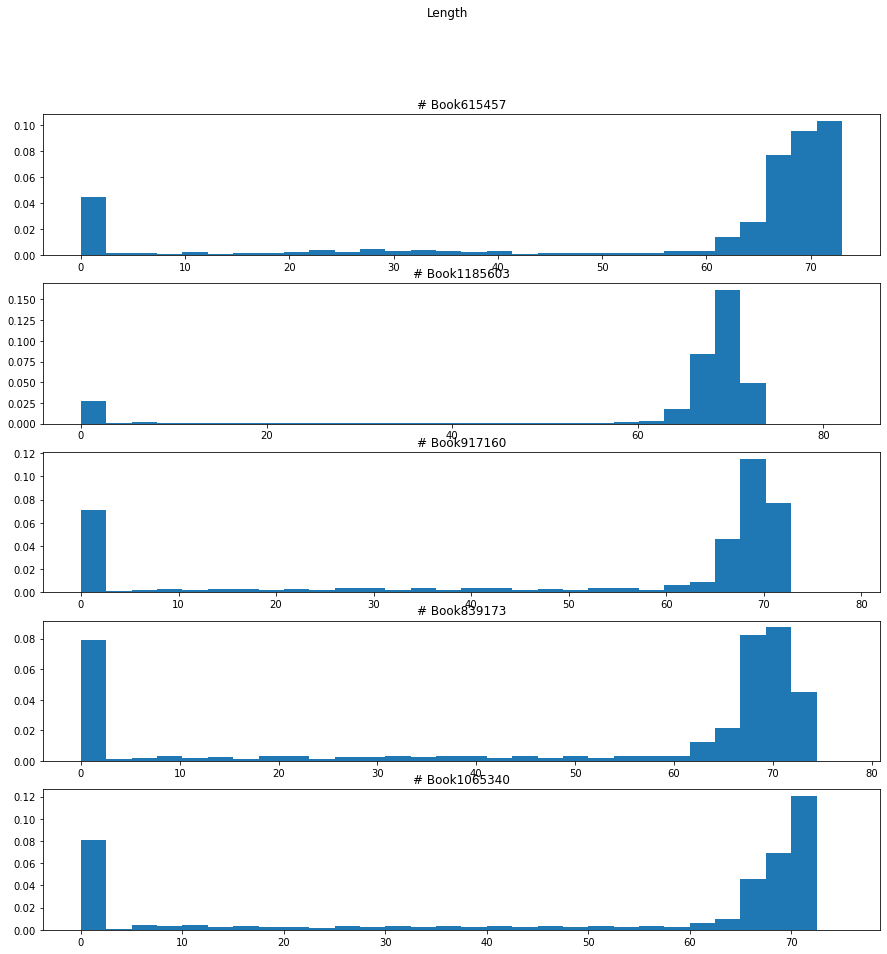

In [6]:
plot_book_paragraph_length()

In [7]:
print("Percent of pargraphs that have characters\n number >=60 in each book")
for index,book in enumerate(get_books_before_filter(books)):
  splited_book = re.split(r"\r\n",book)
  good_paragraphs = [paragraph for paragraph in splited_book if len(paragraph)>=60]
  print(" ".join(["Book #",str(index),"-->",str(len(good_paragraphs)/len(splited_book)*100),"%"]))

Percent of pargraphs that have characters
 number >=60 in each book
Book # 0 --> 77.00698497751411 %
Book # 1 --> 86.53701514988718 %
Book # 2 --> 65.9641486741882 %
Book # 3 --> 64.70371281042537 %
Book # 4 --> 62.78031166856708 %


In [8]:
def get_books(books_links:list) -> list:
    book_list= []
    for book in get_books_before_filter(books_links):
        splited_book = re.split(r"\r\n",book)
        good_paragraphs = [paragraph for paragraph in splited_book if len(paragraph)>=60]
        book_list.append(" ".join(good_paragraphs))
    return book_list

## Preprocessing

In [9]:
def cleanUp(lstTxt: list) -> list:
    
    '''
        1- CleanUp.
            1.1 include numbers and alphabets only.
            1.2 Change Case to lower case.
            1.3 Remove extra spaces.
            1.4 remove leading whitespaces.
            1.5 Replace punctuation with whitespaces
    '''
    cleaned_lst = []
    for txt in lstTxt:
        txt = re.sub(r'[^A-Z a-z]', ' ', txt)# include only alphabets and numbers
        txt = re.sub(' +', ' ', txt)# remove extra spaces
        txt = txt.lower()#convert to lower case
        txt = txt.strip()# remove leading whitespaces
        txt = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', txt) #Replace punctuation with whitespaces
        cleaned_lst.append(txt)
    return cleaned_lst


In [10]:
def stopWordRemoval(book_lst: list) -> list:
    l = []
    for book in book_lst:
        words = word_tokenize(book)
        good_tokens = []
        for word in words:
            if word not in stop_words:
                good_tokens.append(word)
        l.append(" ".join(good_tokens))
    return l

In [11]:
def partitioning(txt:str) -> list:
    
    '''
        This function tries to partition a string into 200 partitions with 100 words for each partition.
        The function expexcts a string and returns a list of strings (where string length is 100) of size 200
        (number of partitions). 
    '''
    
    try:
        
        res = [] # where the result will be
        beg = 0 # an index for the beginning of the partition
        end = 100# an end for the last index we seek
        lst_txt = re.split(' ', txt)
        for i in range(200):
            res.append(' '.join(lst_txt[beg:end]))
            beg = end
            end += 100
           
        return res
    
    except TypeError:
        print("Please specifiy a string as an argument")

In [12]:
labels=['A', 'B', 'C', 'D', 'E']
def MakeDatafram(lst:list, index:int) -> pd.DataFrame:
    
    '''
        The function consumes a list which is the list of text srings of the book and also an integer which is
        the index of the book in the all list of books and produces a dataframe that maps the lst 
        and the index together into two columns.
        
    '''
    df = pd.DataFrame({'Text': lst,'label':[labels[index]]*200})
    return df

In [13]:
def StackDataFrames(lst:list) -> pd.DataFrame:
    return pd.concat(lst,ignore_index=True)

In [14]:
def prepare(books: list) -> pd.DataFrame:
    '''
        1- select 200 random sample of each book, each record is 100 words.
        2- Label them.
        3- return a DataFrame of all the labeled data.
    '''
    i = 0
    lst_dfs = []
    
    for book in books:
        partition = partitioning(book)
        df = MakeDatafram(partition, i)
        lst_dfs.append(df)
        i += 1
    return StackDataFrames(lst_dfs)

In [15]:
def pre_processing(books: list) -> pd.DataFrame:
    '''
        Aggregate all the preprocessing tasks in one place.
    '''
    cleaned = cleanUp(books)
    without_stop = stopWordRemoval(cleaned)
    
    return prepare(without_stop)

In [16]:
df = pre_processing(get_books(books))

In [17]:
df

,Text,label
0,project gutenberg ebook ancient egypt george r...,A
1,two marked varieties physique two types charac...,A
2,builders khufu shafra menkaura pyramids tombs ...,A
3,dimensions amenemhat labyrinth pyramid wanderi...,A
4,quit egypt early wars thothmes ethiopia nubia ...,A
...,...,...
995,entangled hundred pros cons feared venture adv...,E
996,events described house charioteer mena resembl...,E
997,sister crossed threshold first time four years...,E
998,royal descent always rested early morning till...,E


## Feature Engineering

### 1. BOW

In [18]:
# Create label encoded y
y_encoded = EncodeLabel(df['label'])

In [19]:
def BOW(df):
    all_Partitions = list(df["Text"])
    
    vectorizer = CountVectorizer(analyzer = "word")
    bow_matrix = vectorizer.fit(all_Partitions)
    feature_names = vectorizer.vocabulary_
    
    bow_matrix = vectorizer.transform(all_Partitions)
    feature_array = bow_matrix.toarray()
    
    display(pd.DataFrame(feature_array, columns=feature_names))
    return feature_array

X_bag_of_words= BOW(df)
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bag_of_words, y_encoded, test_size = 0.20, random_state=42)


,project,gutenberg,ebook,ancient,egypt,george,rawlinson,use,anyone,anywhere,...,ptolemaic,macedonian,philadelphus,arsinoe,saturn,squandered,compensate,insults,heaped,benefactor
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Training BOW

#### A. BOW with SVM

In [20]:
models_acc = []
models_pred = []


In [21]:
clf_bow_svm = SVC(kernel='linear', C =200, probability=True)
clf_bow_svm =OneVsRestClassifier(LinearSVC())

# train model
clf_bow_svm = classify_train(X_train_bow, y_train_bow, clf_bow_svm)[0]
# make predictions
pred_bow_svm = classify(X_train_bow, y_train_bow, X_test_bow, clf_bow_svm)[1]

Assessing the model

### 10-Fold Cross validation

In [22]:
cross_validation(clf_bow_svm, 5, 10 ,0.2, X_train_bow, y_train_bow)

Accuracy using cross validation with 10-Fold
 Iteration: 1 Accuracy: 1.00 
 Iteration: 2 Accuracy: 0.99 
 Iteration: 3 Accuracy: 0.99 
 Iteration: 4 Accuracy: 1.00 
 Iteration: 5 Accuracy: 0.99 
 Iteration: 6 Accuracy: 0.99 
 Iteration: 7 Accuracy: 0.97 
 Iteration: 8 Accuracy: 0.99 
 Iteration: 9 Accuracy: 0.97 
 Iteration: 10 Accuracy: 0.99 
Total accuracy: 0.99 (+/- 0.02)


### Error Analysis
Looking At the confusion matrix might help identify what went wrong with the classifier.

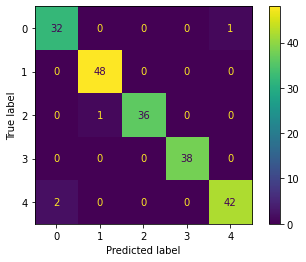

0.98

In [23]:
ModelAssemesment(y_test_bow, pred_bow_svm, clf_bow_svm)

With accuraccy 97% on Test set and 98% on validation set, it's safe to say that our classifier is doing a very good job. 

The errors happen when distinguishing between first and last authors, and between second and third author.

#### B. BOW with KNN

In [24]:
clf_bow_knn = KNeighborsClassifier()
pred_bow_knn = classify(X_train_bow, y_train_bow, X_test_bow, clf_bow_knn)[1]

### 10-Fold Cross Validation

In [25]:
cross_validation(clf_bow_knn, 5, 10 ,0.2, X_train_bow, y_train_bow)

Accuracy using cross validation with 10-Fold
 Iteration: 1 Accuracy: 0.88 
 Iteration: 2 Accuracy: 0.94 
 Iteration: 3 Accuracy: 0.85 
 Iteration: 4 Accuracy: 1.00 
 Iteration: 5 Accuracy: 0.90 
 Iteration: 6 Accuracy: 0.95 
 Iteration: 7 Accuracy: 0.89 
 Iteration: 8 Accuracy: 0.89 
 Iteration: 9 Accuracy: 0.90 
 Iteration: 10 Accuracy: 0.93 
Total accuracy: 0.91 (+/- 0.08)


### Error Analysis

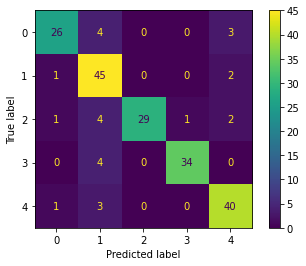

0.87

In [26]:
ModelAssemesment(y_test_bow, pred_bow_knn, clf_bow_knn)

Our classifier's accuraccy on test set is about 89%, and on validation set is about 90%, which indicates that there is a little bit some mis-learned features implicitly in the model.

Looking at the confusion matrix, we find that the model can perfectly classify the second Author's texts, but most of the error happens because the model chooses the second and the last author. 

Our classifier is pretty good at classifying second Author correctly. But this not the problem.
In a fany terminology, we would say that ther is a bias towards the second and the last author. This also indicates that we want to decrease the **FP** rate of the class 1.

We can inject more text into the classifier that has a lot of similar tokens as the Book of the second Author and make the classifier learn to distinguish them.

#### C. BOW with Decision Tree

In [27]:
clf_bow_dtr = DecisionTreeClassifier()
pred_bow_dtr = classify(X_train_bow, y_train_bow, X_test_bow, clf_bow_dtr)[1]

### 10-Fold Cross validation

In [28]:
cross_validation(clf_bow_dtr, 5, 10 ,0.2, X_train_bow, y_train_bow)

Accuracy using cross validation with 10-Fold
 Iteration: 1 Accuracy: 0.79 
 Iteration: 2 Accuracy: 0.90 
 Iteration: 3 Accuracy: 0.78 
 Iteration: 4 Accuracy: 0.81 
 Iteration: 5 Accuracy: 0.78 
 Iteration: 6 Accuracy: 0.82 
 Iteration: 7 Accuracy: 0.80 
 Iteration: 8 Accuracy: 0.74 
 Iteration: 9 Accuracy: 0.75 
 Iteration: 10 Accuracy: 0.72 
Total accuracy: 0.79 (+/- 0.10)


### Error Analysis

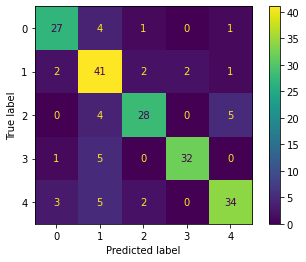

0.81

In [29]:
ModelAssemesment(y_test_bow, pred_bow_dtr, clf_bow_dtr)

With an acuraccy of 75% on test data, our classifier is doing a really bad job in classifying the texts correctly. We can easilt say that decision tree is not able to handle the classification properly, hence, it's worth not to depend on it as a main model. 

## 2. Training TF-IDF

In [30]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(df['Text'], y_encoded)
def TF_IDF(df: pd.DataFrame):
    
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_train_tf)

    tfidf_transformer = TfidfTransformer()
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

    X_test_counts = count_vect.transform(X_test_tf)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    
    return X_train_counts, X_train_tfidf,X_test_counts, X_test_tfidf

X_train_counts, X_train_tfidf,X_test_counts, X_test_tfidf = TF_IDF(df)

### 1. TF-IDF with SVM

In [31]:
clf_tf_svm = SVC(kernel='linear', C =200, probability=True)
clf_tf_svm = OneVsRestClassifier(LinearSVC())

pred_tf_svm = classify(X_train_tfidf, y_train_tf, X_test_tfidf, clf_tf_svm)[1]

### 10-Fold Cross Validation

In [32]:
cross_validation(clf_tf_svm, 5, 10 ,0.2, X_train_tfidf, y_train_tf)

Accuracy using cross validation with 10-Fold
 Iteration: 1 Accuracy: 0.96 
 Iteration: 2 Accuracy: 1.00 
 Iteration: 3 Accuracy: 0.99 
 Iteration: 4 Accuracy: 1.00 
 Iteration: 5 Accuracy: 1.00 
 Iteration: 6 Accuracy: 1.00 
 Iteration: 7 Accuracy: 0.97 
 Iteration: 8 Accuracy: 1.00 
 Iteration: 9 Accuracy: 1.00 
 Iteration: 10 Accuracy: 0.99 
Total accuracy: 0.99 (+/- 0.03)


### Error Analysis

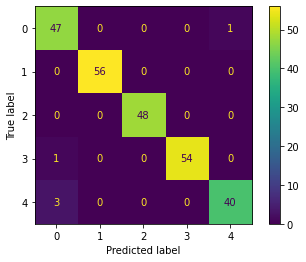

0.98

In [33]:
ModelAssemesment(y_test_tf, pred_tf_svm, clf_tf_svm)

The model is doing a very good job classifying the text.

### 2. TF-IDF with KNN

In [34]:
clf_tf_knn = KNeighborsClassifier()
pred_tf_knn = classify(X_train_tfidf, y_train_tf, X_test_tfidf, clf_tf_knn)[1]

## 10-Fold Cross Validation

In [35]:
cross_validation(clf_tf_knn, 5, 10 ,0.2, X_train_tfidf, y_train_tf)

Accuracy using cross validation with 10-Fold
 Iteration: 1 Accuracy: 0.91 
 Iteration: 2 Accuracy: 0.95 
 Iteration: 3 Accuracy: 0.97 
 Iteration: 4 Accuracy: 0.95 
 Iteration: 5 Accuracy: 0.96 
 Iteration: 6 Accuracy: 0.93 
 Iteration: 7 Accuracy: 0.93 
 Iteration: 8 Accuracy: 0.99 
 Iteration: 9 Accuracy: 0.96 
 Iteration: 10 Accuracy: 0.97 
Total accuracy: 0.95 (+/- 0.04)


### Error Analysis

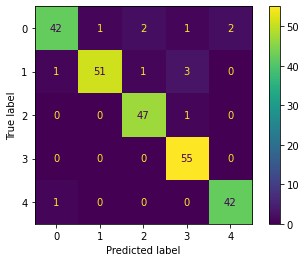

0.948

In [36]:
ModelAssemesment(y_test_tf, pred_tf_knn, clf_tf_svm)

### 3. TF-IDF with Decision Tree

In [37]:
clf_tf_dtr = DecisionTreeClassifier()
pred_tf_dtr = classify(X_train_tfidf, y_train_tf, X_test_tfidf, clf_tf_dtr)[1]


### 10-Fold Cross Validation

In [38]:
cross_validation(clf_tf_dtr, 5, 10 ,0.2, X_train_tfidf, y_train_tf)

Accuracy using cross validation with 10-Fold
 Iteration: 1 Accuracy: 0.79 
 Iteration: 2 Accuracy: 0.85 
 Iteration: 3 Accuracy: 0.76 
 Iteration: 4 Accuracy: 0.84 
 Iteration: 5 Accuracy: 0.80 
 Iteration: 6 Accuracy: 0.69 
 Iteration: 7 Accuracy: 0.75 
 Iteration: 8 Accuracy: 0.79 
 Iteration: 9 Accuracy: 0.71 
 Iteration: 10 Accuracy: 0.67 
Total accuracy: 0.76 (+/- 0.12)


### Error Analysis

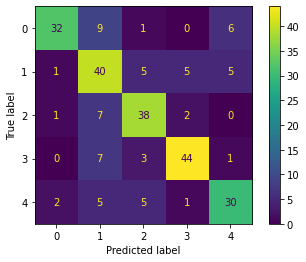

0.736

In [39]:
ModelAssemesment(y_test_tf, pred_tf_dtr, clf_tf_dtr)

## 3. N-Gram

In [40]:
def N_gram(X):
    matrix_ngram = TfidfVectorizer(ngram_range=(1, 2),max_features=270,binary=True)

    X_ngram= matrix_ngram.fit_transform(X).toarray()

    X_ngram_vector = pd.DataFrame(X_ngram,columns = matrix_ngram.get_feature_names())
    return X_ngram_vector


X_train_ngr, X_test_ngr, y_train_ngr, y_test_ngr = train_test_split(df['Text'], y_encoded)

X_train_ngr = N_gram(X_train_ngr)
X_test_ngr = N_gram(X_test_ngr)
print(X_train_ngr.shape, y_train_ngr.shape, X_test_ngr.shape, y_test_ngr.shape)

(750, 270) (750,) (250, 270) (250,)


In [41]:
def N_gram_2(df ,ngram):
    vectorizer2 = TfidfVectorizer(analyzer='word', ngram_range=(2, ngram))
    X2 = vectorizer2.fit_transform(df['Text'])
    return X2


X2 = N_gram_2(df, 2)
X_train_ngr, X_test_ngr, y_train_ngr, y_test_ngr = train_test_split(X2, y_encoded)

## N-gram Training

### 1. N-gram with SVM

In [42]:
clf_ngr_svm = SVC(kernel='linear', C =200, probability=True)
clf_ngr_svm =OneVsRestClassifier(LinearSVC())
pred_ngr_svm = classify(X_train_ngr, y_train_ngr, X_test_ngr, clf_ngr_svm)[1]

### 10-Fold Cross Validation

In [43]:
cross_validation(clf_ngr_svm, 5, 10 ,0.2, X_train_ngr, y_train_ngr)

Accuracy using cross validation with 10-Fold
 Iteration: 1 Accuracy: 0.88 
 Iteration: 2 Accuracy: 0.85 
 Iteration: 3 Accuracy: 0.92 
 Iteration: 4 Accuracy: 0.89 
 Iteration: 5 Accuracy: 0.77 
 Iteration: 6 Accuracy: 0.88 
 Iteration: 7 Accuracy: 0.91 
 Iteration: 8 Accuracy: 0.93 
 Iteration: 9 Accuracy: 0.88 
 Iteration: 10 Accuracy: 0.91 
Total accuracy: 0.88 (+/- 0.08)


### Error Analysis

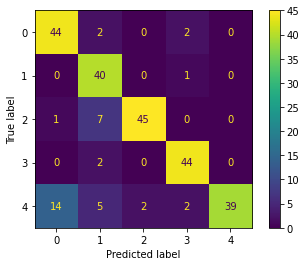

0.848

In [44]:
ModelAssemesment(y_test_ngr, pred_ngr_svm, clf_ngr_svm)

In [45]:
clf_ngr_knn = KNeighborsClassifier()
pred_ngr_knn = classify(X_train_ngr, y_train_ngr, X_test_ngr, clf_ngr_knn)[1]

In [46]:
clf_ngr_dtr = DecisionTreeClassifier()
pred_ngr_dtr = classify(X_train_ngr, y_train_ngr, X_test_ngr, clf_ngr_dtr)[1]


In [47]:
# from mlxtend.evaluate import bias_variance_decomp
# from sklearn import preprocessing
# kf = KFold(n_splits=10,shuffle=True,random_state=0)
# yy_train=np.copy(y_train_ngr)
# yy_test=np.copy(y_test_ngr)
# lab_encod = preprocessing.LabelEncoder()
# mse, bias, var = bias_variance_decomp(clf_ngr_svm, X_train_ngr.values,lab_encod.fit_transform( yy_train), X_test_ngr.values,lab_encod.fit_transform(yy_test), num_rounds=200, random_seed=1)
# print("MSE:",mse)
# print("Bias:",bias)
# print("Varience:",var)
# plot_learning_curve(clf_ngr_svm, "SVM Learning Curve", X_train_ngr, y_train_ngr, (0.7, 1.01),kf, n_jobs=4)

# plt.show()

## Choosing Best model from The whol combination

In [48]:
cols = ['Accuraccy', 'Precision', 'Recall', 'F1-score']

indices = ['BOW + SVM','BOW + KNN','BOW + Dec.Tree','TFIDF + SVM', 'TFIDF + KNN', 'TFIDF + Dec.Tree',
           'N-gram+SVM', 'N-gram+KNN', 'N-gram+Dec.Tree']

df_metrics = pd.DataFrame(columns=cols, index=indices)

clf_lst = [clf_bow_svm, clf_bow_knn, clf_bow_dtr, clf_tf_svm, clf_tf_knn, clf_tf_dtr
           ,clf_ngr_svm, clf_ngr_knn, clf_ngr_dtr]

clf_pred = [pred_bow_svm, pred_bow_knn, pred_bow_dtr, pred_tf_svm, pred_tf_knn, pred_tf_dtr
            ,pred_ngr_svm, pred_ngr_knn, pred_ngr_dtr]

y_test_chosen = [y_test_bow, y_test_bow, y_test_bow, y_test_tf, y_test_tf, y_test_tf,
                 y_test_ngr, y_test_ngr, y_test_ngr]

i = 0
for p in clf_pred:
    #print(p.shape, y_test_chosen[i].shape, i)
    acc = round(accuracy_score(p, y_test_chosen[i]), 3)
    recall = round(recall_score(p, y_test_chosen[i], average='weighted'), 3)
    precision = round(precision_score(p, y_test_chosen[i], average='weighted'), 3)
    f1 = round(f1_score(p, y_test_chosen[i], average='weighted'), 3)
    s = np.array((acc, precision, recall, f1))
    #print(s)    
    df_metrics.iloc[i, :] = s
    #row.append(s)
    i += 1
df_metrics

,Accuraccy,Precision,Recall,F1-score
BOW + SVM,0.98,0.98,0.98,0.98
BOW + KNN,0.87,0.879,0.87,0.869
BOW + Dec.Tree,0.81,0.813,0.81,0.808
TFIDF + SVM,0.98,0.98,0.98,0.98
TFIDF + KNN,0.948,0.951,0.948,0.948
TFIDF + Dec.Tree,0.736,0.739,0.736,0.733
N-gram+SVM,0.848,0.88,0.848,0.85
N-gram+KNN,0.84,0.848,0.84,0.841
N-gram+Dec.Tree,0.584,0.683,0.584,0.575


### LDA: A more advanced preprocessing.

In [49]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
def sk_Lda():
    model=LatentDirichletAllocation(n_components=10,learning_method='online',random_state=42,max_iter=50)
    return model

In [50]:
vect =TfidfVectorizer(stop_words=stop_words,max_features=1000)
vect_text=vect.fit_transform(df['Text'])
#print(vect_text)
lda_model =sk_Lda()
lda_top=lda_model.fit_transform(vect_text)#lda_top enters the training phase
lda_top.shape

(1000, 10)

In [51]:
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(lda_top, y_encoded)
#clf_bow_svm = SVC(kernel='linear', C =200, probability=True)
clf_svm_lda =KNeighborsClassifier()
clf_svm_lda = SVC()
clf_lda, pred_lda = classify(X_train_lda, y_train_lda, X_test_lda, clf_svm_lda)
#ModelAssemesment(y_test_lda, pred_lda, clf_lda)

In [52]:
def doc_relation_rate(lda_top , num):
    print("Paragraph ",num,": ")
    for i,topic in enumerate(lda_top[num]):
        print("Author ",i,": ",topic*100,"%")

In [53]:
def topic_Modeling():
    vocab = vect.get_feature_names()

    for i, comp in enumerate(lda_model.components_):
        vocab_comp = zip(vocab, comp)
        sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:20]
        print("Author "+str(i)+": ")
        for t in sorted_words:
            print(t[0],end=" ")
        print("\n")

In [54]:
doc_relation_rate(lda_top,0)

Paragraph  0 : 
Author  0 :  1.8423016798374492 %
Author  1 :  1.8423016798316452 %
Author  2 :  1.8423016798440432 %
Author  3 :  83.4192848814788 %
Author  4 :  1.8423016798292902 %
Author  5 :  1.842301679831816 %
Author  6 :  1.8423016798350664 %
Author  7 :  1.842301679835454 %
Author  8 :  1.842301679842049 %
Author  9 :  1.8423016798343856 %


In [55]:
topic_Modeling()

Author 0: 
egypt amenemhat reign thebes hundred pyramid great power tribes land one made time slaves south life north works syria place 

Author 1: 
river nile egypt monarch waters zanzibar period land sea africa numerous year large two seem either bear kings heads country 

Author 2: 
egypt nile name expedition city religion claridge son years thothmes set great ancient world life served egyptian men war england 

Author 3: 
would one said men could man time egypt great two upon like us thee first well made david day know 

Author 4: 
osiris good sun temple soul light memphis king monarch makes sea nature religion walls also flat upon god two green 

Author 5: 
thee heaven delta amenemhat spring used elder king entire monuments lower living god even season appeared tombs egypt spirit nile 

Author 6: 
egypt egyptian pyramid reign feet animal death sacred character native subjects art memphis great evil general egyptians ii considerable question 

Author 7: 
thothmes great elder thee e

## LDA using pyLDAvis

In [56]:
def towords(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))

In [57]:
data_words = list(towords(df['Text']))

In [58]:
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]#TF

In [59]:

def LDA_Model(corpus,id2word):
    num_topics = 5
    # Build LDA model
    lda = gensim.models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=5,random_state=12345,chunksize=100,per_word_topics=True)
    pprint(lda.print_topics())
    doc_lda = lda[corpus]
    return lda

In [60]:
lda_model.score(vect_text)
print("Model Perplexity: ", lda_model.perplexity(vect_text))

Model Perplexity:  2320.4172277393


In [61]:
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(LDA_Model(corpus,id2word), corpus, id2word)
LDAvis_prepared

[(0,
  '0.009*"would" + 0.007*"one" + 0.006*"said" + 0.003*"man" + 0.003*"made" + '
  '0.003*"upon" + 0.003*"two" + 0.003*"men" + 0.003*"time" + 0.003*"could"'),
 (1,
  '0.010*"one" + 0.008*"would" + 0.006*"said" + 0.005*"could" + 0.004*"time" + '
  '0.004*"man" + 0.004*"like" + 0.003*"may" + 0.003*"know" + 0.003*"go"'),
 (2,
  '0.007*"one" + 0.007*"would" + 0.006*"men" + 0.006*"said" + 0.004*"two" + '
  '0.004*"thee" + 0.004*"man" + 0.004*"could" + 0.003*"upon" + 0.003*"egypt"'),
 (3,
  '0.006*"one" + 0.005*"would" + 0.004*"great" + 0.004*"said" + 0.004*"men" + '
  '0.004*"egypt" + 0.004*"time" + 0.003*"two" + 0.003*"first" + 0.003*"made"'),
 (4,
  '0.008*"would" + 0.007*"said" + 0.006*"one" + 0.005*"could" + 0.004*"time" + '
  '0.003*"great" + 0.003*"life" + 0.003*"egypt" + 0.003*"day" + 0.003*"upon"')]


/home/ahmed/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ahmed/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ahmed/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/ahmed/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.008219  0.010850       1        1  24.300283
1     -0.024307  0.006139       2        1  21.538086
3     -0.000478  0.003518       3        1  19.564506
4      0.016225  0.004327       4        1  17.615468
0      0.000341 -0.024834       5        1  16.981657, topic_info=        Term        Freq       Total Category  logprob  loglift
1094   would  708.000000  708.000000  Default  30.0000  30.0000
493   priest   55.000000   55.000000  Default  29.0000  29.0000
1006    feet  148.000000  148.000000  Default  28.0000  28.0000
1203   could  374.000000  374.000000  Default  27.0000  27.0000
4501   ameni   46.000000   46.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
877      way   32.502106  193.771812   Topic5  -6.2574  -0.0123
999      day   33.712769  225.119626   Topic5  -6.2208  -0.1257
4256      go   32.485446  205.405711   Topic5  -6.2579  -0.0712
109     life   31.697812  199.855565   Topic5  -6.2824  -0.0683
2321    know   31.439977  220.379288   Topic5  -6.2906  -0.1742

[444 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
3819      1  0.528274  acres
3819      3  0.176091  acres
3819      4  0.176091  acres
3819      5  0.176091  acres
2347      1  0.228120  altar
...     ...       ...    ...
460       1  0.240612  years
460       2  0.311904  years
460       3  0.151496  years
460       4  0.151496  years
460       5  0.142585  years

[1102 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 5, 1])

## Word Empedding (Doc2vec)


In [62]:
from sklearn.model_selection import train_test_split
df = pre_processing(get_books(books))
X = df['Text']
y = df['label']
X_train_Doc2Vec, X_test_Doc2Vec, y_train_Doc2Vec, y_test_Doc2Vec = train_test_split(X, y, stratify=y, test_size=0.2,random_state=42)

import gensim
def read_corpus(curpus_df, tages=None):
    for i in range(0,len(curpus_df)):
        tokens = gensim.utils.simple_preprocess(curpus_df.iloc[i])
        if tages is None:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [tages.iloc[i]])

def train_model_using_Doc2Vec(train_corpus):
    doc2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
    doc2vec_model.build_vocab(train_corpus)
    doc2vec_model.train(train_corpus, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
    return doc2vec_model

def get_predictions_using_Doc2Vec(doc2vec_model,test_corpus):
    predicted_labels_with_similarty = pd.DataFrame(columns = ['predicted_label','similarty'])
    for line in test_corpus:
        inferred_vector = doc2vec_model.infer_vector(line)
        # get top similar topic (topn=1)
        sims = doc2vec_model.dv.most_similar([inferred_vector], topn=1)
        key,sim = sims[0]
        temp = pd.DataFrame([[key,sim]],columns = ['predicted_label','similarty'])
        predicted_labels_with_similarty = pd.concat([predicted_labels_with_similarty,temp],ignore_index=True)
    return predicted_labels_with_similarty

train_corpus = list(read_corpus(X_train_Doc2Vec,y_train_Doc2Vec))
test_corpus = list(read_corpus(X_test_Doc2Vec))

trained_model = train_model_using_Doc2Vec(train_corpus)
predicted_set = get_predictions_using_Doc2Vec(trained_model,test_corpus)
print(predicted_set)

from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test_Doc2Vec, predicted_set['predicted_label'])*100,'%')
print(classification_report(y_test_Doc2Vec, predicted_set['predicted_label']))
#metrics.ConfusionMatrixDisplay.from_predictions(y_test_Doc2Vec,predicted_set['predicted_label'])

    predicted_label  similarty
0                 C   0.846319
1                 A   0.887055
2                 B   0.817508
3                 B   0.918621
4                 D   0.879307
..              ...        ...
195               A   0.748253
196               B   0.914903
197               C   0.768767
198               A   0.764928
199               D   0.879343

[200 rows x 2 columns]
Accuracy: 97.5 %
              precision    recall  f1-score   support

           A       0.91      1.00      0.95        40
           B       0.98      1.00      0.99        40
           C       1.00      0.95      0.97        40
           D       1.00      0.97      0.99        40
           E       1.00      0.95      0.97        40

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.98       200
weighted avg       0.98      0.97      0.98       200

